In this notebook, we will use Spark APIs to implement [Matrix Factorizationan and Alternating Least Squares](https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea) (ALS) algorithm and predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/). The approach used here can be applied to other rating datasets as well. **This notebook has to run in Spark environment.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

## Data Exploration

Let's load the data and do a quick inspection.

In [2]:
movies = spark.read.load("ml-latest-small/movies.csv", format='csv', header = True)
ratings = spark.read.load("ml-latest-small/ratings.csv", format='csv', header = True)
links = spark.read.load("ml-latest-small/links.csv", format='csv', header = True)
tags = spark.read.load("ml-latest-small/tags.csv", format='csv', header = True)

In [3]:
movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [4]:
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
+------+-------+------+----------+
only showing top 5 rows



In [5]:
links.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [6]:
tags.show(5)

+------+-------+--------------------+----------+
|userId|movieId|                 tag| timestamp|
+------+-------+--------------------+----------+
|    15|    339|sandra 'boring' b...|1138537770|
|    15|   1955|             dentist|1193435061|
|    15|   7478|            Cambodia|1170560997|
|    15|  32892|             Russian|1170626366|
|    15|  34162|         forgettable|1141391765|
+------+-------+--------------------+----------+
only showing top 5 rows



Because the goal of this notebook is to predict ratings, I'll not explore "movies", "links" and "tags" much. But just out of curiosity, let's check how the movies distribute across various genres.

In [7]:
movies.groupby("genres").count().orderBy("count", ascending=False).show()

+--------------------+-----+
|              genres|count|
+--------------------+-----+
|               Drama| 1170|
|              Comedy|  809|
|        Comedy|Drama|  425|
|         Documentary|  365|
|       Drama|Romance|  356|
|      Comedy|Romance|  341|
|Comedy|Drama|Romance|  264|
|              Horror|  183|
|      Drama|Thriller|  172|
|         Crime|Drama|  135|
|Crime|Drama|Thriller|  116|
|     Horror|Thriller|  112|
|           Drama|War|  107|
|        Comedy|Crime|   77|
|            Thriller|   74|
|       Action|Comedy|   67|
|     Children|Comedy|   64|
|     Action|Thriller|   57|
|       Comedy|Horror|   57|
|        Action|Drama|   53|
+--------------------+-----+
only showing top 20 rows



It's not surprising that Drama and Comedy are the most dominant types. Many movies are labeled as multiple genres. It would be better if we make each distinct genre a column and count the number of movies that are labeled as each of them. However, this is out of the scope of this work. Below are some numbers for the rating data.

In [8]:
print 'Distinct values of ratings:'
print sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect())

Distinct values of ratings:
[u'0.5', u'1.0', u'1.5', u'2.0', u'2.5', u'3.0', u'3.5', u'4.0', u'4.5', u'5.0']


In [9]:
tmp1 = ratings.groupBy("userID").count().select('count').rdd.min()[0]
tmp2 = ratings.groupBy("movieId").count().select('count').rdd.min()[0]
print 'For the users that rated movies and the movies that were rated:'
print 'Minimum number of ratings per user is {}'.format(tmp1)
print 'Minimum number of ratings per movie is {}'.format(tmp2)

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [10]:
tmp1 = ratings.groupBy("movieId").count().withColumnRenamed("count", "rating count")\
.groupBy("rating count").count().orderBy('rating count').first()[1]
# Or use pandas: tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print '{} out of {} movies are rated by only one user'.format(tmp1, tmp2)

3063 out of 9066 movies are rated by only one user


In [11]:
print "Number of users:", ratings.select('userId').union(tags.select('userId')).distinct().count()

Number of users: 671


In [12]:
print "Number of users who rated movies:", ratings.select('userId').distinct().count()

Number of users who rated movies: 671


In [13]:
print "Number of movies:", ratings.select('movieId').union(tags.select('movieId')).distinct().count()

Number of movies: 9125


In [14]:
print "Number of rated movies:", ratings.select('movieId').distinct().count()

Number of rated movies: 9066


## Process Data for Training
We will use a dataframe-based API from [pyspark.ml](https://spark.apache.org/docs/latest/ml-collaborative-filtering.html) to predict the ratings. First, we need to convert the rating dataframe to the right form for the model.

In [15]:
ratings = ratings.select("userId", "movieId", "rating")

In [16]:
# inspect the schema of the data frame
ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)



The userId and movieId have to be integers, and the rating has to be float numbers.

In [17]:
# Below is a correct and efficient way to change the column types, but it somehow produced 
# errors on my laptop later when working on the dataframe due to some java issues...
# So I used the withColumn() method instead

"""
from pyspark.sql.types import *

schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("rating", FloatType(), True)])

df = spark.createDataFrame(ratings.rdd, schema)
"""

df = ratings.withColumn('userId', ratings['userId'].cast('int')).\
withColumn('movieId', ratings['movieId'].cast('int')).withColumn('rating', ratings['rating'].cast('float'))

In [18]:
# inspect the schema again
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)



I will split the data into training/validation/testing sets using a 60/20/20 split.

In [19]:
train, validation, test = df.randomSplit([0.6,0.2,0.2], seed = 0)

In [20]:
print "The number of ratings in each set: {}, {}, {}".format(train.count(), validation.count(), test.count())

The number of ratings in each set: 60004, 20027, 19973


## Benchmark

Here I define a benchmark model which simply uses the mean rating of each movie (in the training set) as the prediction. We can later compare our model performance with this benchmark.

In [21]:
mean_rating = train.groupby('movieId').mean().select('movieId','avg(rating)')
mean_rating = mean_rating.withColumnRenamed('avg(rating)','prediction')
mean_rating.show(5)

+-------+------------------+
|movieId|        prediction|
+-------+------------------+
|   1580|3.6327433628318584|
|   3175|          3.515625|
|   1088| 3.264705882352941|
|   1645|             3.325|
|   2366| 3.611111111111111|
+-------+------------------+
only showing top 5 rows



We can use SQL to combine the above predictions and the testing set dataframe.

In [22]:
test.createOrReplaceTempView("test")
mean_rating.createOrReplaceTempView("mean_rating")

sqlDF = spark.sql("select test.*, mean_rating.prediction \
                   from test join mean_rating \
                   on test.movieId = mean_rating.movieId")
sqlDF.show(5)

+------+-------+------+------------------+
|userId|movieId|rating|        prediction|
+------+-------+------+------------------+
|     1|     31|   2.5| 3.185185185185185|
|     1|   1129|   2.0|3.1666666666666665|
|     1|   1263|   2.0|3.8636363636363638|
|     2|     39|   5.0|3.5616438356164384|
|     2|     47|   4.0| 4.025547445255475|
+------+-------+------+------------------+
only showing top 5 rows



To evaluate the model performance on the testing set, we will use root-mean-square error (RMSE) as the metric.

In [23]:
# Define a function to calculate RMSE

from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

def RMSE(predictions):
    return evaluator.evaluate(predictions)

In [24]:
print 'Using the mean rating of each movie as the prediction, the testing RMSE is ' + str(RMSE(sqlDF))

Using the mean rating of each movie as the prediction, the testing RMSE is 0.999525001621


## Model Selection and Evaluation

Now we can run the ALS algorithm. Using this model, we can do a grid search to find the optimal hyperparameters. We will use the RMSE of the validation set to evaluate each model.

In [25]:
# Define a function to perform grid search and find the best ALS model
# based on the validation RMSE

from pyspark.ml.recommendation import ALS

def GridSearch(train, valid, num_iterations, reg_param, n_factors):
    min_rmse = float('inf')
    best_n = -1
    best_reg = 0
    best_model = None
    for n in n_factors:
        for reg in reg_param:
            als = ALS(rank = n, 
                      maxIter = num_iterations, 
                      seed = 0, 
                      regParam = reg,
                      userCol="userId", 
                      itemCol="movieId", 
                      ratingCol="rating", 
                      coldStartStrategy="drop")            
            model = als.fit(train)
            predictions = model.transform(valid)
            rmse = RMSE(predictions)     
            print '{} latent factors and regularization = {}: validation RMSE is {}'.format(n, reg, rmse)
            if rmse < min_rmse:
                min_rmse = rmse
                best_n = n
                best_reg = reg
                best_model = model
                
    pred = best_model.transform(train)
    train_rmse = RMSE(pred)
    print '\nThe best model has {} latent factors and regularization = {}:'.format(best_n, best_reg)
    print 'traning RMSE is {}; validation RMSE is {}'.format(train_rmse, min_rmse)
    return best_model

In [26]:
num_iterations = 10
ranks = [6, 8, 10, 12]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

start_time = time.time()
final_model = GridSearch(train, validation, num_iterations, reg_params, ranks)
print 'Total Runtime: {:.2f} seconds'.format(time.time() - start_time)

6 latent factors and regularization = 0.05: validation RMSE is 1.02203363995
6 latent factors and regularization = 0.1: validation RMSE is 0.954438052853
6 latent factors and regularization = 0.2: validation RMSE is 0.924770729779
6 latent factors and regularization = 0.4: validation RMSE is 0.985705320681
6 latent factors and regularization = 0.8: validation RMSE is 1.19828898699
8 latent factors and regularization = 0.05: validation RMSE is 1.02972976705
8 latent factors and regularization = 0.1: validation RMSE is 0.951760819297
8 latent factors and regularization = 0.2: validation RMSE is 0.922537908145
8 latent factors and regularization = 0.4: validation RMSE is 0.985313259158
8 latent factors and regularization = 0.8: validation RMSE is 1.19829732375
10 latent factors and regularization = 0.05: validation RMSE is 1.03636326726
10 latent factors and regularization = 0.1: validation RMSE is 0.950379421009
10 latent factors and regularization = 0.2: validation RMSE is 0.92343893087

The runtime is about 160 seconds. We will use an RDD-based approach in [Spark_MovieLens_RDD.ipynb](Spark_MovieLens_RDD.ipynb) and see if the runtime is different. So the model with 8 latent factors and lambda = 0.2 yields the best result. Let's do a second grid search around these values with more iterations (15) for each model.

In [27]:
num_iterations = 15
ranks = [7, 8, 9]
reg_params = [0.1, 0.2, 0.3]

final_model = GridSearch(train, validation, num_iterations, reg_params, ranks)

7 latent factors and regularization = 0.1: validation RMSE is 0.95097372416
7 latent factors and regularization = 0.2: validation RMSE is 0.925118410924
7 latent factors and regularization = 0.3: validation RMSE is 0.94787509625
8 latent factors and regularization = 0.1: validation RMSE is 0.950515198158
8 latent factors and regularization = 0.2: validation RMSE is 0.923712922344
8 latent factors and regularization = 0.3: validation RMSE is 0.947078377034
9 latent factors and regularization = 0.1: validation RMSE is 0.950582803733
9 latent factors and regularization = 0.2: validation RMSE is 0.923303643645
9 latent factors and regularization = 0.3: validation RMSE is 0.947200079093

The best model has 9 latent factors and regularization = 0.2:
traning RMSE is 0.686163366237; validation RMSE is 0.923303643645


So the model with 9 latent factors and lambda = 0.2 yields the best result.

We can see the testing error is consistent with the validation error:

In [28]:
pred_test = final_model.transform(test)
print 'The testing RMSE is ' + str(RMSE(pred_test))

The testing RMSE is 0.922537488773


Although the RMSE dosen't look like a big improvement from the benchmark (RMSE ~ 1.0), this is pretty much the best we can achieve. You can check out some of the results using other models [here](http://surpriselib.com/).

## Visualization

We can make plots to compare the true and predicted ratings for the training and testing sets.

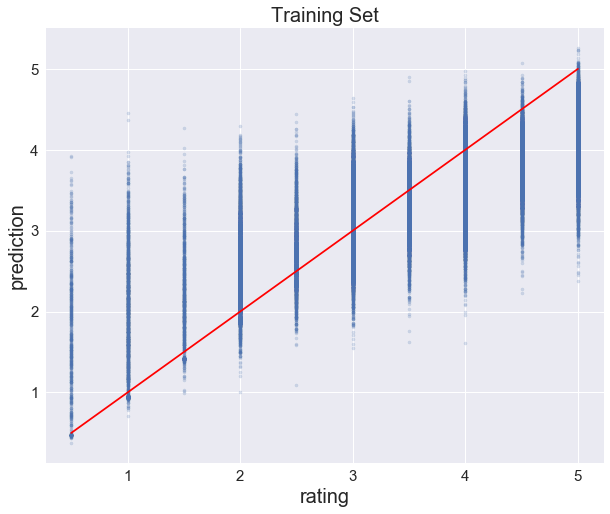

In [29]:
pred_train = final_model.transform(train)
df = pred_train.toPandas()
x = np.arange(0.5, 5.1, 0.5) # To draw the red one-to-one line below

fig = plt.figure(figsize=(10,8))
plt.tick_params(labelsize=15)
plt.scatter(df.rating, df.prediction, s = 10, alpha = 0.2)
plt.plot(x, x, c = 'r')
plt.xlabel('rating', fontsize=20)
plt.ylabel('prediction', fontsize=20)
plt.title('Training Set', fontsize=20)
plt.show()

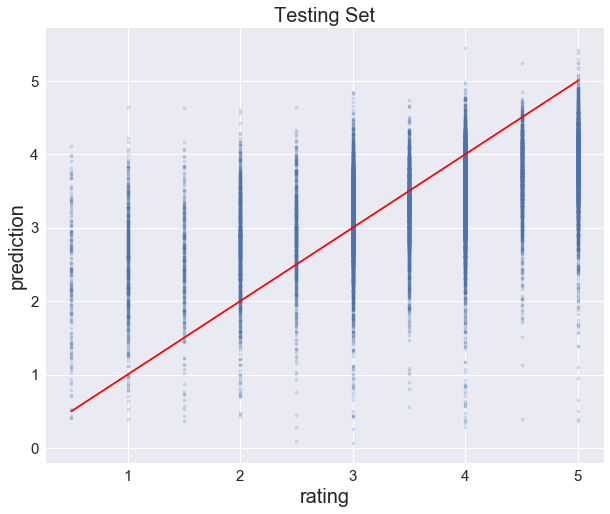

In [30]:
df = pred_test.toPandas()
fig = plt.figure(figsize=(10,8))
plt.tick_params(labelsize=15)
plt.scatter(df.rating, df.prediction, s = 10, alpha = 0.2)
plt.plot(x, x, c = 'r')
plt.xlabel('rating', fontsize=20)
plt.ylabel('prediction', fontsize=20)
plt.title('Testing Set', fontsize=20)
plt.show()

A model with more latent factors can definitely fit the training data better, but it won't generalize wlll on the testing data.